# Advanced Topics in Molecular Dynamics
Gábor Csányi (Engineering Laboratory, Cambridge, UK)

# jupyter 

ju(lia) py(thon) ter(minal)



## Lecture 1: Tools

* Jupyter notebooks: compute and plotting environment
* Julia language: best bits of Matlab and Python, just-in-time compiled http://julialang.org
 * (Python also possible: interfaces to atomistic tools are via Python anyway)
* ASE (Atomic Simulation Environment), a Python package to manage atomic configurations
 * Homepage: https://wiki.fysik.dtu.dk/ase/
 * James Kermode's fork: https://gitlab.com/jameskermode/ase
* QUIP (QUantum mechanics and Interatomic Potentials) https://github.com/libAtoms/QUIP
 * many potentials and their combinations, including wrappers to other codes, Python interface
* LAMMPS (Large-scale Atomic/Molecular Massively Parallel Simulator) http://lammps.sandia.gov

# Lecture 2: Molecular Dynamics

* Discretisation, Langevin thermostats
* Sampling error, error bars
* The hydrogen bond in the water dimer
* Thermal expansion of the water hexamer


# Lecture 3: Function fitting and interpolation

* Kernel fitting (basis functions, regularisation)
* Gaussian process (variance, noise tolerance)
* Free energy suface reconstruction: fitting a function from noisy derivatives
 

# Lecture 4: Fitting interatomic potentials

* Notions of locality in quantum mechanics
* Body expansion (materials systems, water dimer)
* Fitting to linear combinations of data: total energies and forces
* Example: bulk silicon, tungsten
* Fitting the difference between potential energy surfaces: helium in tungsten  


# Lecture 5: Atomisic and molecular descriptors

* An incomplete desriptor: unordered interatomic distances, reconstruction test
* Smooth Overlap of Atomic Positions (SOAP)
* SOAP as an order parameter: identify structures and defects
* Molecular and period structures: the reMATCH kernel
* Map of chemical space


# Lecture 6: Thermodynamics from first principles

* Partition function, response functions
* First order phase transitions
* Nested sampling
* Lennard-Jones clusters, condensed phase diagram
* Comparison to parallel tempering, Wang-Landau


In [4]:
include("mdlecturesrc.jl")

In [5]:
miframe("http://julialang.org")

PyObject <IPython.lib.display.IFrame object at 0x321b92790>

In [6]:
miframe("https://wiki.fysik.dtu.dk/ase/")

PyObject <IPython.lib.display.IFrame object at 0x321b92d50>

In [7]:
miframe("http://lammps.sandia.gov")

PyObject <IPython.lib.display.IFrame object at 0x321c99150>

## Create a molecule

In [8]:
h2o = quippy.Atoms(n=3, lattice=[10 0 0 ; 0 10 0 ; 0 0 10], numbers=[8,1,1],
                    positions=[0 0 0; 0.96 0 0 ; -0.23 0.93 0]);

In [9]:
imolecule_draw(h2o)

PyObject <IPython.core.display.HTML object>

## Parametrisation of the water monomer potential enegy surface by Partridge and Schwenke

Harry Partridge & David W Schwenke, The Journal of Chemical Physics, __106__ 4618–4639 (1997)

_The determination of an accurate isotope dependent potential energy surface for water from extensive ab initio calculations and experimental data._



In [10]:
ps = quippy.Potential("IP PartridgeSchwenke force_using_fd=T", 
                        param_filename="quip_params.xml");

In [11]:
ps[:calc](h2o, args_str="energy"); println(h2o[:energy])

0.000285506217698177


In [12]:
x,y = grids.meshgrid(-1.0:0.05:0.4, [(-1.25:0.05:-0.4) ;(0.4:0.05:1.25)])
h2o_ps_energy = zeros(x)
for i=1:length(x)
    h2o[:set_positions]([0 0 0; 0.96 0 0 ; x[i] y[i] 0])
    ps[:calc](h2o, args_str="energy"); h2o_ps_energy[i] = h2o[:energy]
end

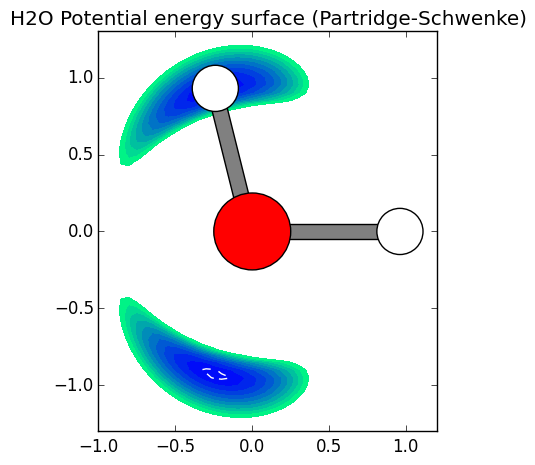

In [13]:
figure(figsize=(7,5))
contourf(x, y, h2o_ps_energy, 0:0.1:1, cmap="winter"); title("H2O Potential energy surface (Partridge-Schwenke)")
contour(x, y, h2o_ps_energy, [0.025], colors="w", linestyles="dashed")
axis([-1, 1.2, -1.3, 1.3])
patch_h2o()
close(gcf())

## Fitting quadratic bond and angle springs

$$
E_\mathrm{quad} = \alpha_0 + \alpha_1 \theta + \alpha_2 \theta^2 + \sum_{i \in \{1,2\}} \beta_0 + \beta_1 r_{\mathrm{OH}_i} + \beta_2 r_{\mathrm{OH}_i}^2
$$

Least squares fit:

$$
\alpha^*, \beta^* = \mathrm{arg}\min_{\alpha,\beta} \sum_{n\in\mathrm{configs}} \left|E_\mathrm{quad}(n | \alpha,\beta) - E_\mathrm{PS}(n)\right|^2
$$

Coefficients in $E_\mathrm{quad}$ are _linear_, so fit can be accomplished by linear algebra, e.g. by choosing configurations in which only one coordinate changes, i.e. one of the bond lengths, or the bond angle

#### Compute the energy as a function of O-H bond distance

In [14]:
r = 0.88:0.01:1.05
Er = zeros(r)
for i=1:length(r)
    h2o[:set_positions]([0 0 0; r[i] 0 0 ; 0.96*cos(105/180*π) 0.96*sin(105/180*π) 0])
    ps[:calc](h2o, args_str="energy"); Er[i] = h2o[:energy]
end

#### Compute the energy as a function of H-O-H bond angle

In [15]:
θ = (90.0:120.0)/180*π
Eθ = zeros(θ)
for i=1:length(θ)
    h2o[:set_positions]([0 0 0; 0.96 0 0 ; 0.96*cos(θ[i]) 0.96*sin(θ[i]) 0])
    ps[:calc](h2o, args_str="energy"); Eθ[i] = h2o[:energy]
end

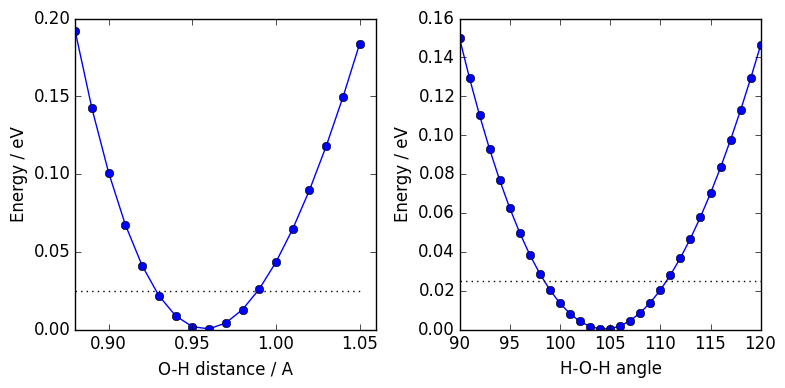

In [16]:
figure(figsize=(8,4))
subplot(121)
plot(r, Er, "o-")
plot([r[1],r[end]], [0.025,0.025], "k:")
xlabel("O-H distance / A"); ylabel("Energy / eV")

subplot(122)
plot(θ*180/π, Eθ, "o-")
plot([θ[1],θ[end]]*180/π, [0.025,0.025], "k:")
xlabel("H-O-H angle "); ylabel("Energy / eV")

tight_layout()
close(gcf())

#### compute coefficients 

$$
\beta^T A \approx E
$$

$$
\left[\begin{matrix}
\beta_0\\
\beta_1\\
\beta_2
\end{matrix}\right]^T
\left[\begin{matrix}
1 & 1 & \ldots & 1\\
r_1(1) & r_1(2) & \ldots & r_1(n)\\
r_1^2(1) & r_1^2(2) & \ldots & r_1^2(n)\\
\end{matrix}\right]
\approx
\left[\begin{matrix}
E(1) & E(2) & \ldots & E(n)
\end{matrix}\right]
$$

$$
\Rightarrow\qquad
\beta^T =  E A^{+}
$$

where $A^{+}$ is the pseudoinverse, such that $A A^{+} = I$, given by $A^{+} = A(AA)^{-1}$

#### Fit quadratic

In [17]:
rr = r[4:14]
A = [ones(length(rr))' ;  rr' ; rr'.^2 ]
bond = A' \ Er[4:14]
θθ = θ[12:20]
A = [ones(length(θθ))' ;  θθ' ; θθ'.^2 ]
angle = A' \ Eθ[12:20]

3-element Array{Float64,1}:
  7.207  
 -7.90664
  2.16861

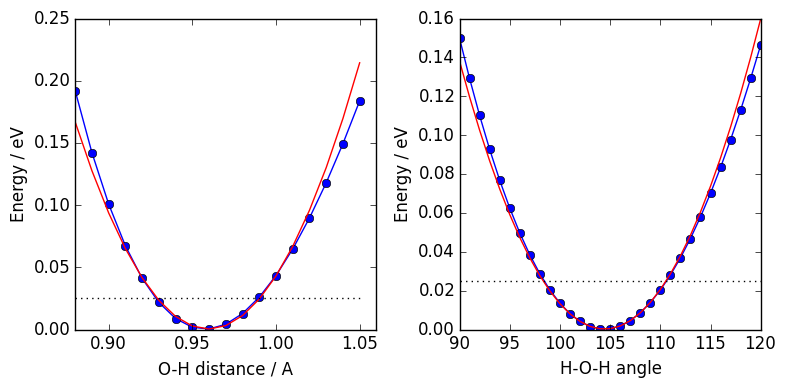

Bond coeffs: [24.164815965260882 -50.360497897436915 26.23872173235223]
Angle coeffs: [7.20699681668473 -7.906640649316323 2.1686148080472876]
θ0 = 104.44850271503907
r0 = 0.9596598952330563


In [19]:
figure(figsize=(8,4))
subplot(121)
plot(r, Er, "o-")
plot(r, bond[1]+bond[2]*r+bond[3]*r.^2, "r-")
plot([r[1],r[end]], [0.025,0.025], "k:")
xlabel("O-H distance / A"); ylabel("Energy / eV")

subplot(122)
plot(θ*180/π, Eθ, "o-")
plot(θ*180/π, angle[1]+angle[2]*θ+angle[3]*θ.^2, "r-")
plot([θ[1],θ[end]]*180/π, [0.025,0.025], "k:")
xlabel("H-O-H angle "); ylabel("Energy / eV")

tight_layout()
close(gcf())

θ0 = (-angle[2]/(2*angle[3]))
r0 = (-bond[2]/(2*bond[3]))
println(" ")
print("Bond coeffs: "); println(bond')
print("Angle coeffs: "); println(angle')
println("θ0 = $(θ0*180/π)")
println("r0 = $r0")

In [20]:
miframe("http://www1.lsbu.ac.uk/water/water_models.html")

PyObject <IPython.lib.display.IFrame object at 0x324f6b790>

## Create a quadratic approximation energy model


In [21]:
function h2o_quad(p)
    bond = [24.1648  -50.3605    26.2387   ]     # coefficients for bond A angstroms
    angle = [7.207    -0.137997   0.000660598]   # coefficient for angle in degrees
    
    r12 = norm(p[4:6]-p[1:3])
    r13 = norm(p[7:9]-p[1:3])
    θ = acos(sum((p[4:6]-p[1:3]).*(p[7:9]-p[1:3]))/(r12*r13))/π*180.0
    E = bond[1]+bond[2]*r12+bond[3]*r12*r12 + bond[1]+bond[2]*r13+bond[3]*r13*r13+
        angle[1]+angle[2]*θ+angle[3]*θ*θ
end


h2o_quad (generic function with 1 method)

In [22]:
xx,yy = grids.meshgrid(-0.45:0.02:-0.05, 0.85:0.01:1.0)
r1 = [0.93,0.94,0.96,0.98,0.985]
h2o_quad_energy_xxyy = zeros(size(xx)..., size(r1)...)
h2o_ps_energy_xxyy = zeros(size(xx)..., size(r1)...)

for j=1:length(r1)
    for i=1:length(xx)
        h2o[:set_positions]([0 0 0; r1[j] 0 0 ; xx[i] yy[i] 0])
        h2o_quad_energy_xxyy[ind2sub(size(xx),i)...,j] = h2o_quad(vec(h2o[:get_positions]()'))
        ps[:calc](h2o, args_str="energy"); h2o_ps_energy_xxyy[ind2sub(size(xx),i)...,j] = h2o[:energy]
    end
end

Interact.Slider{Int64}(Signal{Int64}(3, nactions=0),"j",3,1:5,true)

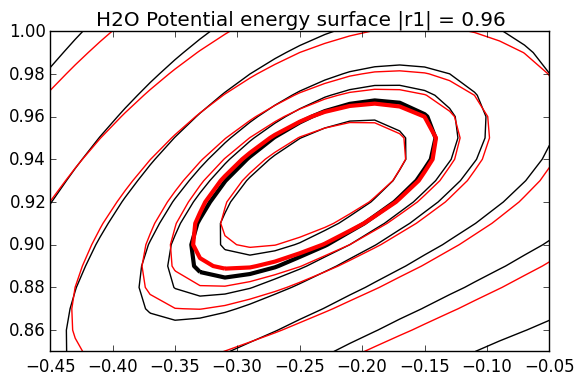

In [23]:
f = figure()
@manipulate for j=1:size(h2o_ps_energy_xxyy,3) withfig(f) do
        contour(xx, yy, h2o_ps_energy_xxyy[:,:,j], [0, 0.015, 0.025, 0.035, 0.05, 0.1, 0.2, 0.4, 0.8, 1.6], colors="k")
        contour(xx, yy, h2o_quad_energy_xxyy[:,:,j], [0, 0.015, 0.025, 0.035, 0.05, 0.1, 0.2, 0.4, 0.8, 1.6], colors="r")
        contour(xx, yy, h2o_ps_energy_xxyy[:,:,j], [0.025], colors="k", linewidths=3) 
        contour(xx, yy, h2o_quad_energy_xxyy[:,:,j], [0.025], colors="r", linewidths=3) 
        axis([-0.45, -0.05, 0.85, 1.0])
        #axis("equal")
        title("H2O Potential energy surface |r1| = $(r1[j])")
        #legend()
        tight_layout()
    end
end


## Geometry optimisation

Finding the configuration with the lowest energy is a standard task of molecular modelling. 

Julia provides the Optim package

In [ ]:
using Optim

In [ ]:
Optim.optimize()

In [24]:
res = optimize(h2o_quad, vec(h2o[:get_positions]()'), ftol=1e-8)

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [0.0,0.0,0.0,0.985,0.0,0.0,-0.05,1.0,0.0]
 * Minimum: [0.09992649908881464,-0.019697021026178343, ...]
 * Value of Function at Minimum: 0.000813
 * Iterations: 144
 * Convergence: true
   * |x - x'| < NaN: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-08: true
   * |g(x)| < NaN: false
   * Exceeded Maximum Number of Iterations: false
 * Objective Function Calls: 276
 * Gradient Call: 0

#### Optimum geometry

In [25]:
res.minimum

9-element Array{Float64,1}:
  0.0999265 
 -0.019697  
  0.23938   
  1.02942   
 -0.185505  
  0.0676642 
  0.00864089
  0.932629  
  0.163932  

In [26]:
p = reshape(res.minimum, (3,3))'

3x3 Array{Float64,2}:
 0.0999265   -0.019697  0.23938  
 1.02942     -0.185505  0.0676642
 0.00864089   0.932629  0.163932 

In [27]:
norm(p[2,:]-p[1,:]), norm(p[3,:]-p[1,:])

(0.959658560973489,0.95966118248791)

## Multiple molecules

Add Coulomb, dispersion (Van der Waals) attraction and Pauli repulsion terms

$$
E = \sum_{i \in \mathrm{H}_2\mathrm{O}} E_\mathrm{quad}(i) + \sum_{ij\in\mathrm{O,H}} \frac{q_i q_j}{|r_{ij}|} + \sum_{i,j\in\mathrm{O}} V_\mathrm{LJ}(r_{ij})
$$

Dispersion attraction and Pauli repulsion are described by the Lennard-Jones potential
$$
V_\mathrm{LJ} = 4 \varepsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right]
$$

In [28]:
function tip3p_energy{T}(p::Vector{T})

    # input vector of positions in this orderL Ox Oy Oz Hx Hy Hz Hx Hy Hz Ox Oy Oz...
    
    qO = -0.8340
    qH = 0.4170
    σ = 3.15061       # in Angstrom
    ε = 0.6364 * 0.01 # conversion from kJ/mol to eV
    bohr = 0.529177249 # 1 Bohr in Angstrom
    hartree = 27.2114  # in eV
    
    E = 0.0
    
    for i=1:length(p)÷9                          # loop over oxygens (i.e. H2O monomers)
        E += h2o_quad(p[(i-1)*9+1:(i-1)*9+9])    # monomer energy
        for j=i+1:length(p)÷9                    # loop over other oxygens 
            O1 = (i-1)*9+1; O2 = (j-1)*9+1
            rij = norm(p[O1:O1+2]-p[O2:O2+2])
            E += 4.0*ε*((σ/rij)^12-(σ/rij)^6)     # LJ term
            # Electrostatics
            Es = 0.0
            Es += qO*qO/rij
            Es += qO*qH*(1/norm(p[O1:O1+2]-p[O2+3:O2+5])
                +1/norm(p[O1:O1+2]-p[O2+6:O2+8])
                +1/norm(p[O1+3:O1+5]-p[O2:O2+2])
                +1/norm(p[O1+6:O1+8]-p[O2:O2+2]))
            Es += qH*qH*(1/norm(p[O1+3:O1+5]-p[O2+3:O2+5])
                +1/norm(p[O1+3:O1+5]-p[O2+6:O2+8])
                +1/norm(p[O1+6:O1+8]-p[O2+3:O2+5])
                +1/norm(p[O1+6:O1+8]-p[O2+6:O2+8]))  
            E += Es*hartree*bohr
        end
    end
    E
end

tip3p_energy (generic function with 1 method)

## Water dimer

In [29]:
h4o2 = quippy.Atoms(n=6, lattice=[10 0 0 ; 0 10 0 ; 0 0 10], numbers=repeat([8,1,1],outer=[2]),
                    positions=[ h2o_p0 ;  h2o_p0 +  repeat([3.0 0 0], outer=[3,1])]);
imolecule_draw(h4o2)

PyObject <IPython.core.display.HTML object>

### Obtaining gradients

Many algorithms, including most geometry optimisation methods and molecular dynamics require the gradient of the potential. Notable exceptions:

* Nelder Mead and other gradient-free optimisation methods (but its much less efficient than ones based on gradients)
* Monte Carlo simulations (although very efficient moves can be generated by including gradient information) 

Options for computing the gradient of a function of _N_ variables: 

* Finite difference (e.g. Ridder's method), cost: O(_N_), optimum balance of roundoff error and truncation error 
* Hand code the gradient function, cost: O(1), but time consuming and prone to bugs
* _Automatic differentiation_: Julia is a language with full introspection, and has several such packages. 

In [30]:
tip3p_grad = ForwardDiff.gradient(tip3p)

g (generic function with 1 method)

In [31]:
h4o2[:rattle](0.1)
res = optimize(tip3p.potential, (p,s)->s[:] = tip3p.gradient(p), vec(h4o2[:get_positions]()'), ftol=1e-4, grtol=1e-2)

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [0.04967141530112327,-0.013826430117118467, ...]
 * Minimum: [0.2688025488197643,-0.37417236642629287, ...]
 * Value of Function at Minimum: -0.297546
 * Iterations: 117
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-04: false
   * |g(x)| < 1.0e-02: true
   * Exceeded Maximum Number of Iterations: false
 * Objective Function Calls: 432
 * Gradient Call: 432

In [32]:
h4o2[:set_positions](reshape(res.minimum, (3,6))')
imolecule_draw(h4o2)

PyObject <IPython.core.display.HTML object>

### Dissociation curve

In [36]:
r = 2.3:0.05:8.0
p0 = h4o2[:get_positions]()
p = copy(p0)
dOO = p0[4,:]- p0[1,:] 
Edim_tip3p = zeros(r)
Edim_fx = zeros(r)
for i=1:length(r)
    p[4:6,:] = p0[4:6,:] + repeat((r[i]/norm(dOO)-1.0)*dOO, outer=[3,1])
    Edim_tip3p[i] = tip3p.potential(vec(p'))
    h4o2[:set_positions](p); fx[:calc](h4o2, args_str="energy"); Edim_fx[i] = h4o2[:energy]
end

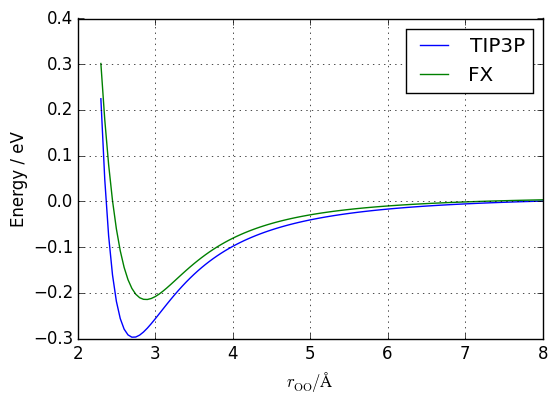

In [37]:
figure()
plot(r, Edim_tip3p, "b-", label="TIP3P")
plot(r, Edim_fx, "g-", label="FX")
grid()
legend()
xlabel(L"r_\mathrm{OO} / \AA"); ylabel("Energy / eV")
close(gcf())

### Interaction of water molecules: TTM3F polarisable force field by Fanourgakis and Xantheas

George S. Fanourgakis and Sotiris S. Xantheas, Journal of Chemical Physics __128__, 074506 (2008)

_Development of transferable interaction potentials for water. V. Extension of the flexible, polarizable, Thole-type model potential (TTM3-F, v. 3.0) to describe the vibrational spectra of water clusters and liquid water_


In [35]:
fx = quippy.Potential("IP FX force_using_fd=T virial_using_fd=T", param_filename="quip_params.xml");

## Create a water hexamer

In [38]:
h12o6 = make_h12o6()
imolecule_draw(h12o6)

PyObject <IPython.core.display.HTML object>

### Optimise its geometry

In [39]:
h12o6[:rattle](0.1)
res = optimize(tip3p.potential, (p,s)->s[:]=tip3p.gradient(p), vec(h12o6[:get_positions]()'),
        ftol=1e-4, grtol=1e-4)

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [0.04967141530112327,-0.013826430117118467, ...]
 * Minimum: [1.715949202392294,1.8977878986146854, ...]
 * Value of Function at Minimum: -2.166272
 * Iterations: 711
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-04: false
   * |g(x)| < 1.0e-04: true
   * Exceeded Maximum Number of Iterations: false
 * Objective Function Calls: 2507
 * Gradient Call: 2507

In [40]:
h12o6[:set_positions](reshape(res.minimum, (3,18))')
imolecule_draw(h12o6)

PyObject <IPython.core.display.HTML object>

### Geometry optimisation via QUIP

In [41]:
fx[:minim](h12o6, "cg", 1e-1, 12, do_pos=true, do_lat=false)
imolecule_draw(h12o6)

Welcome to minim()
space is 63 dimensional
Method: Conjugate Gradients
cg iter = 1 df^2 = 4.68845069840228934 f = -1.80394317826730544 max(abs(df)) = .62205579197560645
 dcos = .00000000000000000  q = .00000000000000000
cg iter = 11 df^2 = .10815715662775015  f = -1.97811977038375097 max(abs(df)) = .11535755458758068
 dcos = .00843729568680532  q = -3227.44251713645098789
Iterations exceeded 12
Goodbye from minim()



PyObject <IPython.core.display.HTML object>

### Geometry optimisation via ASE: preconditioning

In [42]:
# ASE preconditioned minimiser
h12o6[:rattle](0.05)
h12o6[:set_calculator](fx)
#ucf = ase_const.UnitCellFilter(h12o6, [false,false,false,false,false,false])
minimiser = ase_precon.LBFGS(h12o6, precon=ase_precon.Exp(A=3.0))
minimiser[:run](fmax=1e-1)
imolecule_draw(h12o6)

LBFGS:   0  13:05:12       -1.177306       4.3101
LBFGS:   1  13:05:14       -1.890941       0.7908
LBFGS:   2  13:05:15       -1.916805       0.5049
LBFGS:   3  13:05:15       -1.941762       0.2714
LBFGS:   4  13:05:16       -1.947698       0.3133
LBFGS:   5  13:05:17       -1.955363       0.2110
LBFGS:   6  13:05:17       -1.965218       0.2331
LBFGS:   7  13:05:18       -1.970915       0.4195
LBFGS:   8  13:05:19       -1.974535       0.1800
LBFGS:   9  13:05:20       -1.976815       0.1832
LBFGS:  10  13:05:21       -1.978023       0.0636


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


PyObject <IPython.core.display.HTML object>

## Random Search

In [ ]:

function random_h12o6()
    random_hex = make_h2o() # start with a single H2O
    for i=1:5               # add 5 more
        h2o = quippy.Atoms(n=3)
        reject = true
        while reject        # try to place each one NOT on top of another
            h2o = make_h2o()
            h2o[:rotate](quippy.random_unit_vector(), rand()*π)
            h2o[:set_positions](h2o[:get_positions]()+repeat(quippy.random_unit_vector()'*2.5, outer=[3,1]))
            reject = false
            for j=1:i       # check for Oxygens being too close
                if norm(h2o[:get_positions]()[1,:] - random_hex[:get_positions]()[(j-1)*3+1,:]) < 2.5
                    reject = true
                    break
                end
            end
        end  
        random_hex[:add_atoms](h2o)
    end
    return random_hex
end

In [45]:
init = []
list = []
for i=1:50
    hex = random_h12o6()
    append!(init, [hex[:copy]()])
    res = optimize(tip3p.potential, (p,s)->s[:]=tip3p.gradient(p), vec(hex[:get_positions]()'),
                ftol=1e-2, grtol=1e-2)
    hex[:set_positions](reshape(res.minimum, (3,18))')
    append!(list, [hex])
    println("Random hexamer $i")
end

Random hexamer 1
Random hexamer 2
Random hexamer 3
Random hexamer 4
Random hexamer 5
Random hexamer 6
Random hexamer 7
Random hexamer 8
Random hexamer 9
Random hexamer 10
Random hexamer 11
Random hexamer 12
Random hexamer 13
Random hexamer 14
Random hexamer 15
Random hexamer 16
Random hexamer 17
Random hexamer 18
Random hexamer 19
Random hexamer 20
Random hexamer 21
Random hexamer 22
Random hexamer 23
Random hexamer 24
Random hexamer 25
Random hexamer 26
Random hexamer 27
Random hexamer 28
Random hexamer 29
Random hexamer 30
Random hexamer 31
Random hexamer 32
Random hexamer 33
Random hexamer 34
Random hexamer 35
Random hexamer 36
Random hexamer 37
Random hexamer 38
Random hexamer 39
Random hexamer 40
Random hexamer 41
Random hexamer 42
Random hexamer 43
Random hexamer 44
Random hexamer 45
Random hexamer 46
Random hexamer 47
Random hexamer 48
Random hexamer 49
Random hexamer 50


In [49]:
#list2=copy(list)
imolecule_draw(list2[5])


PyObject <IPython.core.display.HTML object>

In [50]:
function compute_h12o6_Rg(x)
    rO = reshape(x, (3,18))[:,1:3:18] # get Oxygen positions
    mr = mean(rO, 2)                  # compute the center of mass
    sqrt(mean(sum((rO-repeat(mr, inner=[1,6])).^2,1)))
end

compute_h12o6_Rg (generic function with 1 method)

In [51]:
E = []; Rg = []
outfile = quippy.CInOutput("hexamers_random_search.xyz", quippy.OUTPUT)
for hex in list
    x = vec(hex[:get_positions]()')
    append!(Rg, [compute_h12o6_Rg(x)])
    append!(E, [tip3p.potential(x)])
    outfile[:write](hex)
end 
outfile[:close]()

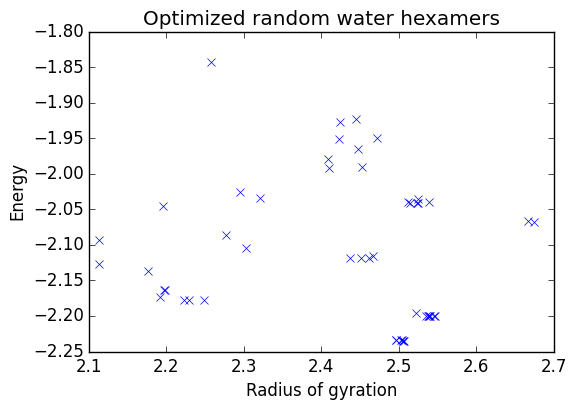

In [52]:
figure()
plot(Rg, E, "x")
xlabel("Radius of gyration"); ylabel("Energy"); title("Optimized random water hexamers")
close(gcf())

## MD via QUIP

In [ ]:

@pyimport quippy._dynamicalsystem as quippy_ds
outfile = quippy.CInOutput("traj.xyz", quippy.OUTPUT)
ds = quippy.DynamicalSystem(h12o6)
ds[:add_thermostat](quippy.THERMOSTAT_LANGEVIN, 300.0, tau=10.0)
@time traj = ds[:run](fx, dt=1.0, n_steps=5, summary_interval=0, save_interval=0, trajectory=outfile, write_interval=1)
outfile[:close]()